# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 8 - Image Classification Using Convolutional Neural Network (CNN) ##
![cnn_classification.png](https://www.researchgate.net/profile/Pham-Quoc-Thang-2/publication/381954145/figure/fig1/AS:11431281258233969@1720019885300/The-CNN-model-is-used-to-classify-images.ppm)

# GPU Settings

**Enable the GPU accelerator in Colab:**

***1. 'Edit' -> 'Notebook settings':***

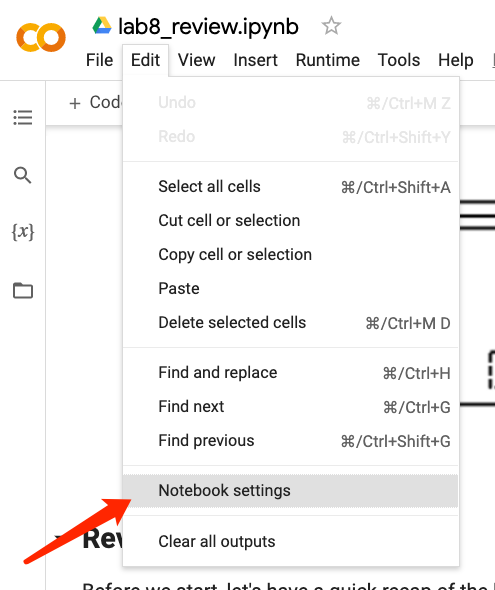


***2. Set 'Hardware accelerator' to 'GPU'***:

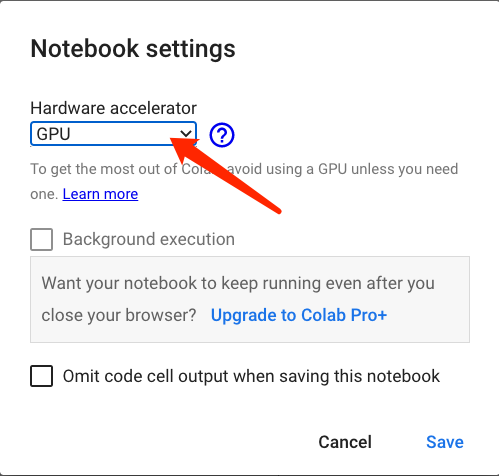

## Check if gpu is enabled

**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    # check your Colab device
    import torch

    GPU_IS_AVAILABLE = torch.cuda.is_available()    # check if gpu is available in your environment
    print(GPU_IS_AVAILABLE)                         # CUDA is available and can be used when it is True

    if GPU_IS_AVAILABLE:
        import subprocess
        out = subprocess.check_output(['nvidia-smi'])
        print(out.decode('utf-8'))

***Note:*** If you use GPU too regularly, runtime durations will become shorter and shorter, and disconnections more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

# **Lab Task Procedure**
(Remember to turn on GPU!)

0. Package import
1. Data preprocessing
2. Data visualization
3. Data augmentation **(Task 1)**
4. Build the model **(Task 2)**
5. Compile the model
6. Train the model
7. Evaluate the model
8. Save and download the model

# Preparations

Simply run the code for some preparation functions.

**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    try:
        import joblib
    except ModuleNotFoundError:
        import sys, subprocess
        out = subprocess.check_output([sys.executable, '-m', 'pip', 'install',
        'joblib'])
        print(out.decode('utf-8'))

In [ ]:
# Import necessary libraries
import numpy as np
import os
import tqdm
import random
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import joblib

if __name__ == "__main__":
    device = "cuda" if GPU_IS_AVAILABLE else "cpu"

# Download and Prepare the Subset of Imagenet Dataset



ImageNet is a large-scale visual database designed for object recognition research in computer vision. It contains over 14 million images categorized according to the WordNet hierarchy, spanning more than 21,000 categories. Each image is annotated with descriptive labels, providing a rich dataset for training and evaluating machine learning models. ImageNet has become a cornerstone in the field, serving as a benchmark for comparing the performance of various object recognition algorithms. Its impact is further highlighted by the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), which spurred significant advancements in deep learning and convolutional neural networks, revolutionizing the field of computer vision. Imagenette is a subset of 10 easily classified classes from Imagenet. Here's a look at some examples from the dataset:

![imagenet_dataset.png](https://radekosmulski.com/content/images/size/w2000/2021/08/imagenet_banner.jpeg)

You can find more information of the dataset from this website: https://www.image-net.org/

**Do not modify the code below.**

Run the code below to download, extract and organize the datasets.

**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    # Prepare data preprocessing tools
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize((0.5,), (0.5,))])

    # Download the dataset
    training_set = torchvision.datasets.Imagenette('./data_train', split="train", transform=transform, download=True)

    # Construct dataloader
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True)

    # Report split sizes
    print('Training set has {} instances'.format(len(training_set)))

In [ ]:
# Download validation dataset
if __name__ == "__main__":
    try:
        import gdown
        import os
        if not os.path.exists('./valset.pkl'):
            gdown.download(id='1Nwhm_H-w9HZ36V5e3PACOLKVz-L9HXVS', output='./valset.pkl')
    except ModuleNotFoundError:
        import sys, subprocess
        out = subprocess.check_output([sys.executable, '-m', 'pip', 'install',
        'gdown'])
        print(out.decode('utf-8'))
        import gdown
        import os
        if not os.path.exists('./valset.pkl'):
            gdown.download(id='1Nwhm_H-w9HZ36V5e3PACOLKVz-L9HXVS', output='./valset.pkl')

In [ ]:
# Prepare validation set
class ImageDataset(Dataset):
    def __init__(self, file_path):
        super().__init__()
        self.data = joblib.load(file_path)
        self.transform = transforms.Compose(
        [transforms.Resize((64,64)),
        transforms.Normalize((0.5,), (0.5,))])

        self.keys = [k for k in self.data.keys()]

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):

        k  = self.keys[idx]

        dict_file = self.data[k]
        image = self.transform(dict_file["image"])
        label = dict_file["label"]

        return image, label

In [ ]:
if __name__ == "__main__":
    validation_set = ImageDataset("./valset.pkl")
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)
    print('Validation set has {} instances'.format(len(validation_set)))

# Visualization

You can try changing the NUM_VIS_IMG in the following code block to view different batches.

Notice that the NUM_VIS_IMG should be **integers** within the valid range of [0,16].

**Do not modify the code below.**


In [ ]:
def matplotlib_imshow(img, one_channel=False):
    plt.axis('off')
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img * 255.0
    npimg = img.numpy().astype(np.uint8)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

if __name__ == "__main__":
    dataiter = iter(training_loader)
    images, labels = next(dataiter)

    NUM_VIS_IMG = 2

    # Create a grid from the images and show them
    img_grid = torchvision.utils.make_grid(images[0:NUM_VIS_IMG])
    matplotlib_imshow(img_grid, one_channel=False)

# Task 1 Data Augmentation


Congratulations! Your dataset is all set and ready to go.
Next, it’s time to build your data augmentation function.
By default, this function doesn’t include any actual data augmentation, but it’s still executable as it is.

Data augmentation is a technique used in deep learning to artificially increase the size and diversity of a dataset. By applying various transformations such as rotation, blurring, flipping, or adding noise to the existing data samples, it helps to create new, slightly different versions of the data. This process is particularly useful in preventing overfitting, where a model becomes too specialized to the training data and performs poorly on unseen data. Data augmentation provides the model with more varied examples to learn from, thereby improving its generalization ability and robustness. It is commonly used in fields of image recognition to enhance model performance without the need for collecting additional real data.


Your task is to implement the data augmentation function with the following features:



*   Random Gaussian Blur
*   Random Horizontal Flip
*   Random Vertical Flip








In [ ]:
def Data_augmentation(img):

    gb_rate = random.random()
    hf_rate = random.random()
    vf_rate = random.random()

    ###############################################################################
    # Build your model with transforms.functional
    # In practical applications, we will not always do data augmentation with 100% rate because excessive augmentation can lead to overfitting the augmented data rather than learning the underlying patterns of the real-world data.
    # We have set up the augmentation rate for you. If the rate >0.5 we perform the corresponding data augmentation. If you are interested, you can experiment it with some other rate.
    # Hint: you may consider using
        # gaussian_blur: https://pytorch.org/vision/master/generated/torchvision.transforms.functional.gaussian_blur.html
        # hflip: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.hflip.html
        # vflip: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.vflip.html

    if gb_rate > 0.5:
        # TODO 1: your code starts here, Hint: gb stands for Gaussian blur

    if hf_rate > 0.5:
        # TODO 2: your code starts here, Hint: hf stands for horizontal flip

    if vf_rate > 0.5:
        # TODO 3: your code starts here, Hint: vf stands for vertical flip

    # TODO: your code ends here
    ###############################################################################

    return img

### Forward image through data augmentation models

Run the code below to see what the augmented images look like.

**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    dataiter = iter(training_loader)
    images, labels = next(dataiter)

    def tensor2fig(img):

        img = img[0].permute(1,2,0)
        img = (img + 1) * 0.5
        img = img * 255.0
        return img.to(torch.uint8)

    # Visualize the augmented images
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = Data_augmentation(images[i: i+1])
        img = tensor2fig(img)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

# Task 2 CNN Model

Now you need to build your own CNN model to let it classify all the flowers.

There is no restriction on the number of layers. For example, you can use the following layers:

* Convolution (`nn.Conv2d`)
* Pooling (`nn.MaxPool2d`, `nn.AvgPool2d`)
* Fully-connected (`nn.Linear`)
* Dropout (`nn.Dropout`)

There is also no restriction on the choice of activation functions. For example, You can use the following activation function:

* SiLU (`F.silu`)
* ELU (`F.elu`)
* ReLU (`F.relu`)


**Reminder: More than 10 million params would result in AT MOST 3 points out of 10 because we won't be able to run your model if it's too large**

In [ ]:
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
    ###############################################################################
    # TODO 1: your code starts here
    # Build your own model using torch.nn
    # Hint: you may consider using
        # nn.Conv2D(in_channels, out_channels, kernel_size, stride, padding): https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # nn.MaxPool2d(kernel_size, stride, padding): https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        # nn.Linear(in_features, out_features): https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # nn.Dropout(rate): https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

    # TODO 1: your code ends here
    ###############################################################################

    def forward(self, x):

    ###############################################################################
    # TODO 2: your code starts here
    # implement your forward function

    # TODO 2: your code ends here
    ###############################################################################
if __name__ == "__main__":
    model = Network().to(device)

## Check Model Size

**Do not modify the code below.**

In [ ]:
#check model size
def model_size(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('model size: {:.3f} M'.format(pytorch_total_params/ 1000000.0))
if __name__ == "__main__":
    model_size(model)

# Training Configuration

Here you have to configure your training setting, including loss, optimizer, and training one epoch function.

Your task is to implement:


*   optimizer
*   loss function
*   training one epoch function

In [ ]:
if __name__ == "__main__":
    ###############################################################################
    # TODO 1: your code starts here
    # Build your own optimizer
    # Hint: you may consider using
        # torch.optim.Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

    # TODO 1: your code ends here
    ###############################################################################


    ###############################################################################
    # TODO 2: your code starts here
    # Build your own Loss function
    # Hint: you may consider using
        # torch.nn.CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

    # TODO 2: your code ends here
    ###############################################################################

    os.makedirs("./ckpts", exist_ok=True)

In [ ]:
def train_one_epoch():

    avg_train_loss = 0.

    pbar = tqdm.tqdm(enumerate(training_loader), initial=0, dynamic_ncols=True, smoothing=0.01)

    for i, data in pbar:
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = Data_augmentation(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)

    ###############################################################################
    # TODO 3: your code starts here


    # TODO 3: your code ends here
    ###############################################################################

    avg_train_loss /= (len(training_set))

    pbar.set_description(
                (
                    f"Iteration {i + 1}: LOSS train {avg_train_loss:.6f}"
                )
            )

    return avg_train_loss

# Train your model

Please be reminded that we will take 15 epochs for grading, so please don't modify that.

In [ ]:
if __name__ == "__main__":
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    epoch_number = 0

    #You can modify EPOCHS to any number as you want
    EPOCHS = 15
    log_info = {"training loss":[], "validation loss": []}

    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):

        ###############################################################################
        # TODO 1: your code starts here

        # hints: Make sure gradient tracking is on, and do a pass over the data

        #update log, hints: log_info["training loss"].append(YOUR_TRAINING_LOSS)

        # TODO 1: your code ends here
        ###############################################################################

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.squeeze(-1).detach().to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.cpu()

        avg_vloss = running_vloss / len(validation_set)
        #update log
        log_info["validation loss"].append(avg_vloss)

        print(f"EPOCH {epoch_number + 1}: LOSS train {avg_loss:.6f} ; LOSS valid {avg_vloss:.6f}")

        # Track the best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            model_path = './ckpts/model_lab8.pt'
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

# Evaluate your model
**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    model.eval()
    correct, total = 0, 0
    # no need to calculate gradients during inference
    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.squeeze(-1).detach().to(device)
            # calculate output by running through the network
            outputs = model(inputs)
            # get the predictions
            __, predicted = torch.max(outputs, 1)
            # update results
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {len(validation_set)} validation data: {100 * correct / total:.4f} %')

## Visualize your own model history
**Do not modify the code below.**

In [ ]:
if __name__ == "__main__":
    x = np.arange(EPOCHS)
    training_info = np.array(log_info["training loss"])
    validation_info = np.array(log_info["validation loss"])

    plt.title("Loss")
    plt.plot(x, training_info)
    plt.plot(x, validation_info)
    plt.legend(["Training Loss", "Validation Loss"], loc="upper right")
    plt.show()

Then click the folder icon on the left of the page, right-click on `model_lab8.pt` under `ckpts` folder, and select `Download`, then you can download the file to your device. Again, your model should have less than 10 million parameters, or it would be too large to download from Colab.

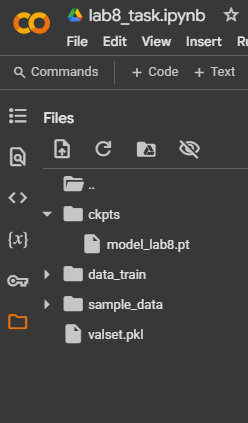

# Submission and Grading

## **ZINC Submission**

1. Save your Python Notebook as a `lab8_task.py` file from Google Colab.
2. Download your trained model `model_lab8.pt`.
3. Zip the `lab8_task.py` and `model_lab8.pt` to a single zip file named `lab8_task.zip`. Zip the two files directly, DO NOT put them in a folder.
4. **Submit the ``.zip`` file** to ZINC.
  (Please make the final submission file size smaller than 200 MB (the zip which contains your lab8_tasks.py and model_lab8.keras) to make the ZINC submission smooth.)

## **Grading scheme**
* You get **1 point** for the valid implementation of data augmentation.
* You get **3 points** for the valid implementation of the CNN model.
* You get **2 points** for achieving at least **45%** accuracy on our private test set.
* You get **4 points** for achieving at least **55%** accuracy on our private test set.
* You get **6 points** (full mark) for achieving at least **65%** accuracy on our private test set.

**Note:**
1. The accuracy on our private test set will be similar to the validation accuracy that you see above. While there may be some difference, a **3%** margin should be safe. In other words, if you wish to get a full mark, then your validation accuracy should be around **68%**.

2. Modifications other than TODO_1 and TODO_2 may not be taken into consideration during grading. Please make sure your TODO_1 and TODO_2 with the original default other codes can work out the desired performance.

3. More than 10 million parameters would result in **AT MOST 3 points** out of 10 because we won't be able to run your model if it's too large.